# Movie Reccomendation System

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

## 1. Data Processing

In [ ]:
data = pd.read_csv("TMBD Movie Recommendation System Dataset.csv")

### 1.1. Data Exploration (EDA)

--- DATASET SHAPE ---
(10000, 18)

--- COLUMNS AND DATA TYPES ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   title                 10000 non-null  object 
 2   release_date          10000 non-null  object 
 3   overview              9995 non-null   object 
 4   keywords              9235 non-null   object 
 5   original_language     10000 non-null  object 
 6   runtime               10000 non-null  int64  
 7   vote_average          10000 non-null  float64
 8   vote_count            10000 non-null  int64  
 9   popularity            10000 non-null  float64
 10  genres                10000 non-null  object 
 11  director              9999 non-null   object 
 12  actor1                10000 non-null  object 
 13  actor2                9972 non-null   object 
 14  actor

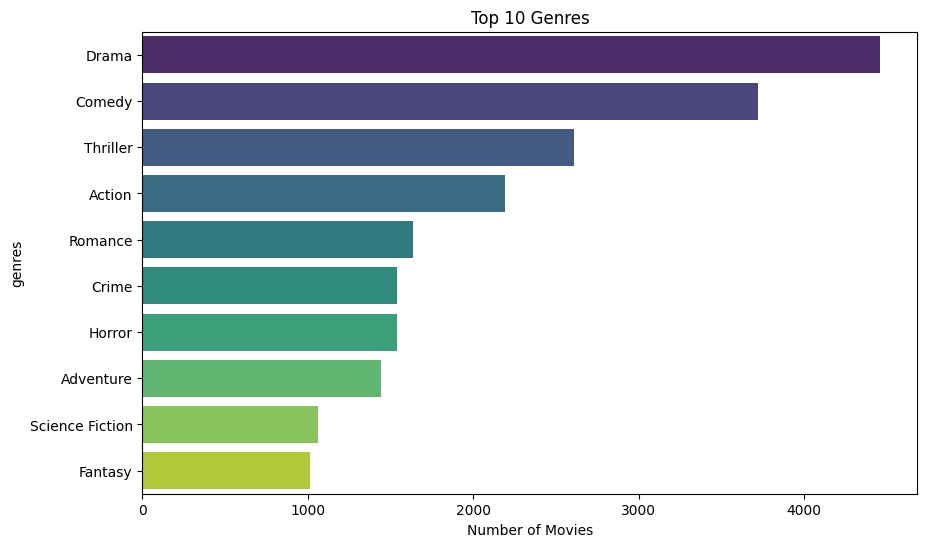

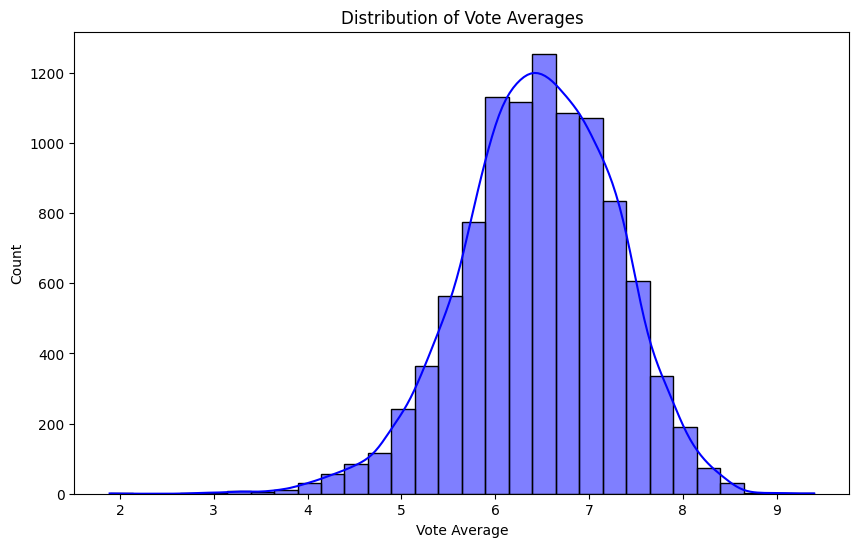

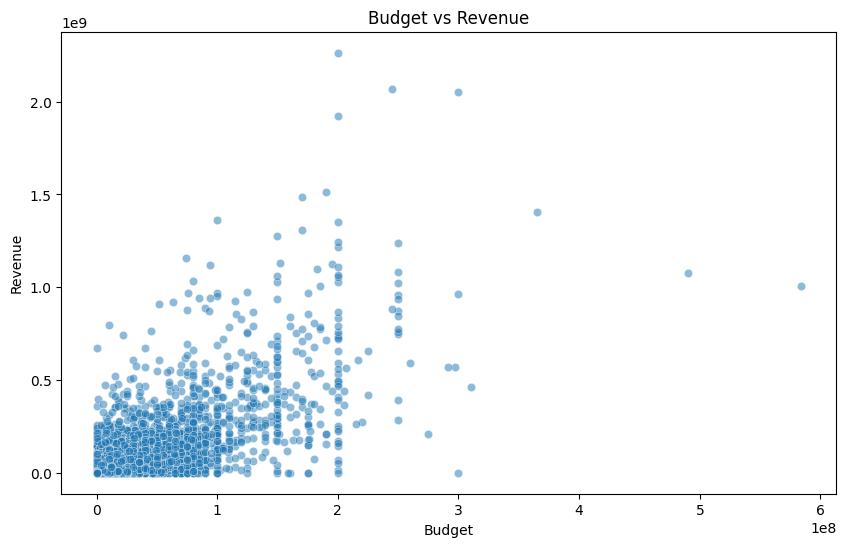

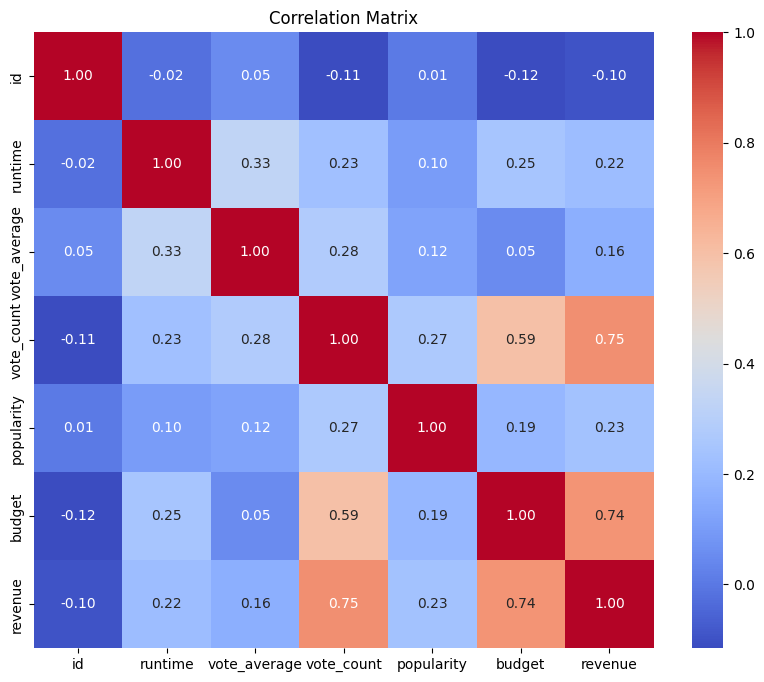

In [ ]:
print("--- DATASET SHAPE ---")
print(data.shape)

print("\n--- COLUMNS AND DATA TYPES ---")
print(data.info())

print("\n--- MISSING VALUES ---")
print(data.isnull().sum())

print("\n--- DUPLICATE ROWS ---")
print(data.duplicated().sum())

print("\n--- NUMERICAL STATISTICS ---")
print(data.describe())

print("\n--- ZERO VALUES IN FINANCIALS ---")
print(f"Movies with 0 Budget: {len(data[data['budget'] == 0])}")
print(f"Movies with 0 Revenue: {len(data[data['revenue'] == 0])}")

print("\n--- TOP 10 LANGUAGES ---")
print(data['original_language'].value_counts().head(10))

print("\n--- TOP 10 PRODUCTION COMPANIES ---")
print(data['production_companies'].str.split(',').explode().str.strip().value_counts().head(10))

print("\n--- GENRE DISTRIBUTION ---")
genre_counts = data['genres'].str.split(',').explode().str.strip().value_counts()
print(genre_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10], hue=genre_counts.index[:10], legend=False, palette='viridis')
plt.title('Top 10 Genres')
plt.xlabel('Number of Movies')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['vote_average'], bins=30, kde=True, color='blue')
plt.title('Distribution of Vote Averages')
plt.xlabel('Vote Average')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='budget', y='revenue', alpha=0.5)
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### 1.2. Data Cleaning

In [ ]:
critical_features = ['overview', 'keywords', 'director']

data = data.dropna(subset=critical_features)

for col in critical_features:
    data = data[data[col].astype(str).str.strip() != '']

def standardize_data(x):
    if isinstance(x, str):
        return x.replace(" ", "").lower()
    return ""

def standardize_list_column(x):
    if isinstance(x, str):
        return ' '.join([standardize_data(i) for i in x.split(',')])
    return ""

In [ ]:
data['director'] = data['director'].apply(standardize_data)
data['actor1'] = data['actor1'].apply(standardize_data)
data['actor2'] = data['actor2'].fillna('').apply(standardize_data)
data['actor3'] = data['actor3'].fillna('').apply(standardize_data)

data['genres'] = data['genres'].apply(standardize_list_column)
data['keywords'] = data['keywords'].apply(standardize_list_column)

data['soup'] = (
    data['keywords'] + ' ' + 
    data['genres'] + ' ' + 
    data['director'] + ' ' + 
    data['actor1'] + ' ' + 
    data['actor2'] + ' ' + 
    data['actor3'] + ' ' + 
    data['overview']
)

output_filename = 'TMDB Clean Data.csv'
data.to_csv(output_filename, index=False)

print("Data cleaning complete.")
print(f"Final Shape: {data.shape}")

Data cleaning complete.
Final Shape: (9232, 19)


## 2. Learning Phase

### 2.1 TF-IDF

#### 2.1.1 TF-IDF Modeling

In [ ]:
filename = 'TMDB Clean Data.csv'

try:
    df = pd.read_csv(filename, keep_default_na=False)
except FileNotFoundError:
    print(f"Error: Could not find {filename}.")
    exit()

tfidf = TfidfVectorizer(stop_words='english')

print("Vectorizing data...")

tfidf_matrix = tfidf.fit_transform(df['soup'])

print("\nFeature Engineering Complete")
print(f"Matrix Shape: {tfidf_matrix.shape}")

with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

with open('tfidf_model.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Files saved: tfidf_matrix.pkl, tfidf_model.pkl")

Vectorizing data...

Feature Engineering Complete
Matrix Shape: (9232, 54220)
Files saved: tfidf_matrix.pkl, tfidf_model.pkl


### 2.1.2. TF-IDF - Cosine Similiarities

In [ ]:
filename = 'TMDB Clean Data.csv'
matrix_file = 'tfidf_matrix.pkl'
try:
    df = pd.read_csv(filename)
    with open(matrix_file, 'rb') as f:
        tfidf_matrix = pickle.load(f)
except FileNotFoundError:
    print(f"Error: Could not find {filename} or {matrix_file}.")
    exit()
print("Calculating Cosine Similarity...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
def get_strength(score):
    if score >= 0.4: return "Strongly Recommended"
    if score >= 0.2: return "Recommended"
    return "You Might Also Like"
def get_recommendations(query, threshold=0.1, cosine_sim=cosine_sim):
    if not isinstance(query, list):
        query = [query]
    valid_movies = [t for t in query if t in indices]
    if not valid_movies:
        return "Error: None of the movies in the list were found."
    print(f"Found movies: {valid_movies}")
    seen = set(valid_movies)
    candidates = []
    for movie in valid_movies:
        idx = indices[movie]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        for i, score in sim_scores[1:]:
            if score >= threshold:
                movie_title = df['title'].iloc[i]
                if movie_title not in seen:
                    candidates.append({
                        'Title': movie_title,
                        'Score': score,
                        'Strength': get_strength(score)
                    })
            else:
                break 
    results_df = pd.DataFrame(candidates)
    if results_df.empty:
        return "No recommendations found above threshold."
    results_df = results_df.sort_values(by='Score', ascending=False)
    results_df = results_df.drop_duplicates(subset='Title')
    results_df.index = range(1, len(results_df) + 1)
    return results_df[['Title']]

Calculating Cosine Similarity...


In [ ]:
my_favorites = ["The Dark Knight", "Inception"]
print(get_recommendations(my_favorites))

Found movies: ['The Dark Knight', 'Inception']
                                             Title
1                            The Dark Knight Rises
2             Batman: The Long Halloween, Part One
3             Batman: The Long Halloween, Part Two
4                                    Batman Begins
5                                           Batman
6                                       The Batman
7                                   Batman Forever
8                  Batman: Mystery of the Batwoman
9                                         The Cell
10                        Batman: The Killing Joke
11         Batman: The Dark Knight Returns, Part 2
12                          The Batman vs. Dracula
13              Batman v Superman: Dawn of Justice
14                                Batman: Year One
15              Batman Beyond: Return of the Joker
16                                  Batman Returns
17                      Batman: Gotham by Gaslight
18         Batman: The Dark Knight 

### 2.2. BERT

#### 2.2.1. BERT Modeling

In [ ]:
filename = 'TMDB Clean Data.csv'
try:
    df = pd.read_csv(filename, keep_default_na=False)
    print(f"Loaded {filename} with {len(df)} movies.")
except FileNotFoundError:
    print(f"Error: Could not find {filename}.")
    exit()
print("Loading BERT model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Encoding movies...")
bert_embeddings = model.encode(df['soup'].tolist(), show_progress_bar=True)
print("\n--- ENCODING COMPLETE ---")
print(f"Embedding Matrix Shape: {bert_embeddings.shape}")
with open('bert_embeddings.pkl', 'wb') as f:
    pickle.dump(bert_embeddings, f)
print("Saved 'bert_embeddings.pkl'. Ready for similarity calculation.")

Loaded TMDB Clean Data.csv with 9232 movies.
Loading BERT model...
Encoding movies...


Batches:   0%|          | 0/289 [00:00<?, ?it/s]


--- ENCODING COMPLETE ---
Embedding Matrix Shape: (9232, 384)
Saved 'bert_embeddings.pkl'. Ready for similarity calculation.


#### 2.2.2. BERT - Cosine Similiarities

In [ ]:
filename = 'TMDB Clean Data.csv'
embeddings_file = 'bert_embeddings.pkl'
try:
    df = pd.read_csv(filename, keep_default_na=False)
    with open(embeddings_file, 'rb') as f:
        bert_embeddings = pickle.load(f)
    print("Loaded Data and BERT Embeddings.")
except FileNotFoundError:
    print(f"Error: Could not find {filename} or {embeddings_file}.")
    exit()
print("Calculating Cosine Similarity...")
cosine_sim = cosine_similarity(bert_embeddings, bert_embeddings)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
def get_bert_recommendations(query, threshold=0.2, cosine_sim=cosine_sim):
    if not isinstance(query, list):
        query = [query]
    valid_movies = [t for t in query if t in indices]
    if not valid_movies:
        return "Error: None of the movies found."
    print(f"Generating BERT recommendations based on: {valid_movies}")
    seen = set(valid_movies)
    candidates = []
    for movie in valid_movies:
        idx = indices[movie]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        for i, score in sim_scores[1:]:
            if score >= threshold:
                title = df['title'].iloc[i]
                if title not in seen:
                    candidates.append({
                        'Title': title,
                        'Score': score
                    })
            else:
                break
    results_df = pd.DataFrame(candidates)
    if results_df.empty:
        return "No recommendations found above threshold."
    results_df = results_df.sort_values(by='Score', ascending=False)
    results_df = results_df.drop_duplicates(subset='Title')
    results_df.index = range(1, len(results_df) + 1)
    return results_df[['Title']]

Loaded Data and BERT Embeddings.
Calculating Cosine Similarity...


In [ ]:
my_favorites = [ "Batman"]
print(get_bert_recommendations(my_favorites, threshold=0.5))

NameError: name 'get_bert_recommendations' is not defined

## 3. Testing

### 3.1 Testing the models using the MovieLens Dataset

Starting Sensitivity Analysis (Comparing Split Ratios)...


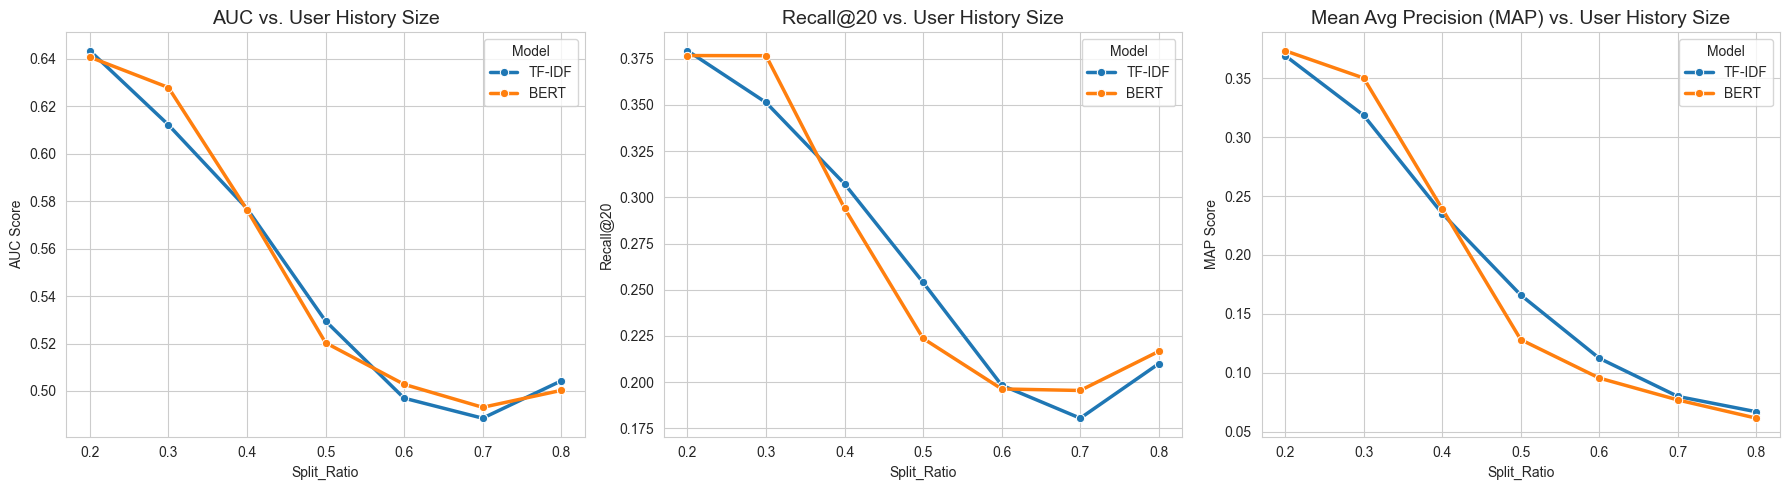


  DETAILED RESULTS: TF-IDF


Split_Ratio,AUC,MAP,Recall@20,Precision@20,FPR_95
0.200000,0.6435,0.3692,0.3793,0.2080,0.8245
0.300000,0.6122,0.3185,0.3513,0.1725,0.8591
0.400000,0.5769,0.2352,0.3073,0.1285,0.8710
0.500000,0.5295,0.1660,0.2539,0.0890,0.8563
0.600000,0.4970,0.1123,0.1983,0.0575,0.8570
0.700000,0.4885,0.0799,0.1805,0.0405,0.8211
0.800000,0.5042,0.0669,0.2100,0.0315,0.7442



  DETAILED RESULTS: BERT


Split_Ratio,AUC,MAP,Recall@20,Precision@20,FPR_95
0.200000,0.6408,0.3733,0.3767,0.2055,0.8763
0.300000,0.6280,0.3501,0.3766,0.1850,0.8620
0.400000,0.5764,0.2391,0.2940,0.1235,0.8672
0.500000,0.5203,0.1281,0.2236,0.0780,0.8637
0.600000,0.5028,0.0955,0.1963,0.0560,0.8383
0.700000,0.4931,0.0770,0.1955,0.0435,0.8275
0.800000,0.5002,0.0615,0.2167,0.0325,0.7501


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
import csv

TEST_DATA_FILE = 'MovieLens_Testing_Dataset.csv' 
N_NEGATIVE_SAMPLES = 100
TOP_K = 20

def calculate_metrics_for_user(user_input, user_hidden, matrix, df_indices):
    valid_input_indices = [df_indices[t] for t in user_input if t in df_indices]
    if not valid_input_indices: return None

    if hasattr(matrix, "toarray"): # TF-IDF
        user_vectors = matrix[valid_input_indices].toarray()
    else:
        user_vectors = matrix[valid_input_indices]
    
    taste_profile = np.mean(user_vectors, axis=0).reshape(1, -1)

    hidden_indices = [df_indices[t] for t in user_hidden if t in df_indices]
    all_indices = set(range(matrix.shape[0]))
    used_indices = set(valid_input_indices + hidden_indices)
    negative_indices = list(all_indices - used_indices)
    
    if len(negative_indices) < N_NEGATIVE_SAMPLES: return None
    negative_samples = np.random.choice(negative_indices, N_NEGATIVE_SAMPLES, replace=False)
    
    eval_indices = hidden_indices + list(negative_samples)
    y_true = [1] * len(hidden_indices) + [0] * len(negative_samples)
    
    if hasattr(matrix, "toarray"): eval_matrix = matrix[eval_indices]
    else: eval_matrix = matrix[eval_indices]
        
    scores = cosine_similarity(taste_profile, eval_matrix).flatten()
    
    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = np.array(y_true)[sorted_indices]
    
    top_k_labels = sorted_labels[:TOP_K]
    hits = np.sum(top_k_labels)
    
    precision = hits / TOP_K
    recall = hits / len(hidden_indices) if len(hidden_indices) > 0 else 0
    try: auc = roc_auc_score(y_true, scores)
    except ValueError: auc = 0.0
    ap = average_precision_score(y_true, scores)
    
    total_pos = np.sum(y_true)
    total_neg = len(y_true) - total_pos
    fpr_95 = 0.0
    if total_pos > 0:
        current_tp = 0
        current_fp = 0
        found_95 = False
        for label in sorted_labels:
            if label == 1: current_tp += 1
            else: current_fp += 1
            if (current_tp / total_pos) >= 0.95:
                fpr_95 = current_fp / total_neg
                found_95 = True
                break
        if not found_95: fpr_95 = 1.0

    return {'Precision@20': precision, 'Recall@20': recall, 'AUC': auc, 'MAP': ap, 'FPR_95': fpr_95}

def run_full_evaluation(matrix, tmdb_data, split_ratio=0.5):
    indices_map = pd.Series(tmdb_data.index, index=tmdb_data['title'])
    indices_map = indices_map[~indices_map.index.duplicated(keep='first')]
    
    metrics_agg = {'Precision@20': [], 'Recall@20': [], 'AUC': [], 'MAP': [], 'FPR_95': []}
    
    try:
        with open(TEST_DATA_FILE, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if not row or len(row) < 2: continue
                raw_titles = row[1]
                movies = [m.strip() for m in raw_titles.split(',')]
                valid_movies = [m for m in movies if m in indices_map]
                
                if len(valid_movies) < 5: continue 
                
                split_index = int(len(valid_movies) * split_ratio)
                if split_index < 1: split_index = 1
                if split_index >= len(valid_movies): split_index = len(valid_movies) - 1
                
                inputs = valid_movies[:split_index]
                hidden = valid_movies[split_index:]
                
                user_res = calculate_metrics_for_user(inputs, hidden, matrix, indices_map)
                if user_res:
                    for k, v in user_res.items(): metrics_agg[k].append(v)
    except FileNotFoundError: return {}

    return {k: np.mean(v) for k, v in metrics_agg.items()}

print("Starting Sensitivity Analysis (Comparing Split Ratios)...")

tmdb_data_source = df 
ratios_to_test = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results_data = []

for ratio in ratios_to_test:
    r_tfidf = run_full_evaluation(tfidf_matrix, tmdb_data_source, split_ratio=ratio)
    r_tfidf['Model'] = 'TF-IDF'
    r_tfidf['Split_Ratio'] = ratio
    results_data.append(r_tfidf)
    
    r_bert = run_full_evaluation(bert_embeddings, tmdb_data_source, split_ratio=ratio)
    r_bert['Model'] = 'BERT'
    r_bert['Split_Ratio'] = ratio
    results_data.append(r_bert)

df_results = pd.DataFrame(results_data)

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=df_results, x='Split_Ratio', y='AUC', hue='Model', marker='o', ax=axes[0], linewidth=2.5)
axes[0].set_title('AUC vs. User History Size', fontsize=14)
axes[0].set_ylabel('AUC Score')

sns.lineplot(data=df_results, x='Split_Ratio', y='Recall@20', hue='Model', marker='o', ax=axes[1], linewidth=2.5)
axes[1].set_title('Recall@20 vs. User History Size', fontsize=14)
axes[1].set_ylabel('Recall@20')

sns.lineplot(data=df_results, x='Split_Ratio', y='MAP', hue='Model', marker='o', ax=axes[2], linewidth=2.5)
axes[2].set_title('Mean Avg Precision (MAP) vs. User History Size', fontsize=14)
axes[2].set_ylabel('MAP Score')

plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("  DETAILED RESULTS: TF-IDF")
print("="*40)

cols = ['Split_Ratio', 'AUC', 'MAP', 'Recall@20', 'Precision@20', 'FPR_95']

df_tfidf = df_results[df_results['Model'] == 'TF-IDF'][cols].sort_values(by='Split_Ratio')

display(df_tfidf.style
        .hide(axis='index')
        .background_gradient(cmap='Blues', subset=['AUC', 'MAP', 'Recall@20'])
        .highlight_max(subset=['Precision@20'], color='lightgreen', axis=0)
        .highlight_min(subset=['FPR_95'], color='lightgreen', axis=0)
        .format("{:.4f}", subset=cols[1:])
       )

print("\n" + "="*40)
print("  DETAILED RESULTS: BERT")
print("="*40)

df_bert = df_results[df_results['Model'] == 'BERT'][cols].sort_values(by='Split_Ratio')

display(df_bert.style
        .hide(axis='index')
        .background_gradient(cmap='Oranges', subset=['AUC', 'MAP', 'Recall@20'])
        .highlight_max(subset=['Precision@20'], color='lightgreen', axis=0)
        .highlight_min(subset=['FPR_95'], color='lightgreen', axis=0)
        .format("{:.4f}", subset=cols[1:])
       )

Starting Sensitivity Analysis (Comparing Split Ratios)...


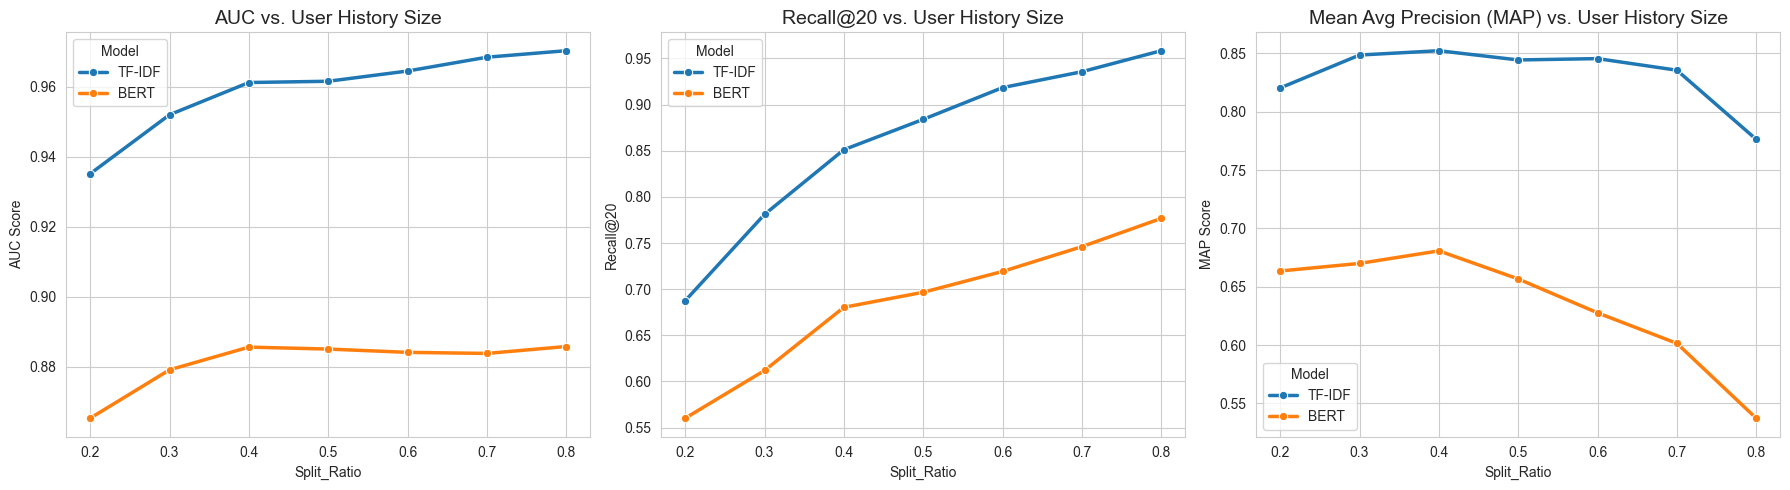


  DETAILED RESULTS: TF-IDF


Split_Ratio,AUC,MAP,Recall@20,Precision@20,FPR_95
0.200000,0.9351,0.8204,0.6875,0.7880,0.2334
0.300000,0.9519,0.8485,0.7810,0.7870,0.1662
0.400000,0.9611,0.8522,0.8511,0.7340,0.2526
0.500000,0.9615,0.8443,0.8840,0.6360,0.2164
0.600000,0.9644,0.8455,0.9183,0.5330,0.1884
0.700000,0.9684,0.8355,0.9356,0.4080,0.1444
0.800000,0.9702,0.7763,0.9583,0.2790,0.0990



  DETAILED RESULTS: BERT


Split_Ratio,AUC,MAP,Recall@20,Precision@20,FPR_95
0.200000,0.8653,0.6635,0.5602,0.6440,0.4294
0.300000,0.8791,0.6700,0.6119,0.6130,0.3776
0.400000,0.8856,0.6808,0.6803,0.5830,0.4926
0.500000,0.8850,0.6567,0.6966,0.4980,0.4802
0.600000,0.8841,0.6277,0.7192,0.4150,0.4506
0.700000,0.8838,0.6015,0.7460,0.3240,0.4014
0.800000,0.8858,0.5374,0.7767,0.2260,0.3180


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity
import csv

TEST_DATA_FILE = 'Gemini_Testing_Dataset.csv' 
N_NEGATIVE_SAMPLES = 100
TOP_K = 20

def calculate_metrics_for_user(user_input, user_hidden, matrix, df_indices):
    valid_input_indices = [df_indices[t] for t in user_input if t in df_indices]
    if not valid_input_indices: return None

    if hasattr(matrix, "toarray"):
        user_vectors = matrix[valid_input_indices].toarray()
    else:
        user_vectors = matrix[valid_input_indices]
    
    taste_profile = np.mean(user_vectors, axis=0).reshape(1, -1)

    hidden_indices = [df_indices[t] for t in user_hidden if t in df_indices]
    all_indices = set(range(matrix.shape[0]))
    used_indices = set(valid_input_indices + hidden_indices)
    negative_indices = list(all_indices - used_indices)
    
    if len(negative_indices) < N_NEGATIVE_SAMPLES: return None
    negative_samples = np.random.choice(negative_indices, N_NEGATIVE_SAMPLES, replace=False)
    
    eval_indices = hidden_indices + list(negative_samples)
    y_true = [1] * len(hidden_indices) + [0] * len(negative_samples)
    
    if hasattr(matrix, "toarray"): eval_matrix = matrix[eval_indices]
    else: eval_matrix = matrix[eval_indices]
        
    scores = cosine_similarity(taste_profile, eval_matrix).flatten()
    
    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = np.array(y_true)[sorted_indices]
    
    top_k_labels = sorted_labels[:TOP_K]
    hits = np.sum(top_k_labels)
    
    precision = hits / TOP_K
    recall = hits / len(hidden_indices) if len(hidden_indices) > 0 else 0
    try: auc = roc_auc_score(y_true, scores)
    except ValueError: auc = 0.0
    ap = average_precision_score(y_true, scores)
    
    total_pos = np.sum(y_true)
    total_neg = len(y_true) - total_pos
    fpr_95 = 0.0
    if total_pos > 0:
        current_tp = 0
        current_fp = 0
        found_95 = False
        for label in sorted_labels:
            if label == 1: current_tp += 1
            else: current_fp += 1
            if (current_tp / total_pos) >= 0.95:
                fpr_95 = current_fp / total_neg
                found_95 = True
                break
        if not found_95: fpr_95 = 1.0

    return {'Precision@20': precision, 'Recall@20': recall, 'AUC': auc, 'MAP': ap, 'FPR_95': fpr_95}

def run_full_evaluation(matrix, tmdb_data, split_ratio=0.5):
    indices_map = pd.Series(tmdb_data.index, index=tmdb_data['title'])
    indices_map = indices_map[~indices_map.index.duplicated(keep='first')]
    
    metrics_agg = {'Precision@20': [], 'Recall@20': [], 'AUC': [], 'MAP': [], 'FPR_95': []}
    
    try:
        with open(TEST_DATA_FILE, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader, None)
            for row in reader:
                if not row or len(row) < 2: continue
                raw_titles = row[1]
                movies = [m.strip() for m in raw_titles.split(',')]
                valid_movies = [m for m in movies if m in indices_map]
                
                if len(valid_movies) < 5: continue 
                
                split_index = int(len(valid_movies) * split_ratio)
                if split_index < 1: split_index = 1
                if split_index >= len(valid_movies): split_index = len(valid_movies) - 1
                
                inputs = valid_movies[:split_index]
                hidden = valid_movies[split_index:]
                
                user_res = calculate_metrics_for_user(inputs, hidden, matrix, indices_map)
                if user_res:
                    for k, v in user_res.items(): metrics_agg[k].append(v)
    except FileNotFoundError: return {}

    return {k: np.mean(v) for k, v in metrics_agg.items()}

print("Starting Sensitivity Analysis (Comparing Split Ratios)...")

tmdb_data_source = df 
ratios_to_test = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results_data = []

for ratio in ratios_to_test:
    r_tfidf = run_full_evaluation(tfidf_matrix, tmdb_data_source, split_ratio=ratio)
    r_tfidf['Model'] = 'TF-IDF'
    r_tfidf['Split_Ratio'] = ratio
    results_data.append(r_tfidf)

    r_bert = run_full_evaluation(bert_embeddings, tmdb_data_source, split_ratio=ratio)
    r_bert['Model'] = 'BERT'
    r_bert['Split_Ratio'] = ratio
    results_data.append(r_bert)

df_results = pd.DataFrame(results_data)

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=df_results, x='Split_Ratio', y='AUC', hue='Model', marker='o', ax=axes[0], linewidth=2.5)
axes[0].set_title('AUC vs. User History Size', fontsize=14)
axes[0].set_ylabel('AUC Score')

sns.lineplot(data=df_results, x='Split_Ratio', y='Recall@20', hue='Model', marker='o', ax=axes[1], linewidth=2.5)
axes[1].set_title('Recall@20 vs. User History Size', fontsize=14)
axes[1].set_ylabel('Recall@20')

sns.lineplot(data=df_results, x='Split_Ratio', y='MAP', hue='Model', marker='o', ax=axes[2], linewidth=2.5)
axes[2].set_title('Mean Avg Precision (MAP) vs. User History Size', fontsize=14)
axes[2].set_ylabel('MAP Score')

plt.tight_layout()
plt.show()

print("\n" + "="*40)
print("  DETAILED RESULTS: TF-IDF")
print("="*40)

cols = ['Split_Ratio', 'AUC', 'MAP', 'Recall@20', 'Precision@20', 'FPR_95']

df_tfidf = df_results[df_results['Model'] == 'TF-IDF'][cols].sort_values(by='Split_Ratio')

display(df_tfidf.style
        .hide(axis='index')
        .background_gradient(cmap='Blues', subset=['AUC', 'MAP', 'Recall@20'])
        .highlight_max(subset=['Precision@20'], color='lightgreen', axis=0)
        .highlight_min(subset=['FPR_95'], color='lightgreen', axis=0)
        .format("{:.4f}", subset=cols[1:])
       )

print("\n" + "="*40)
print("  DETAILED RESULTS: BERT")
print("="*40)

df_bert = df_results[df_results['Model'] == 'BERT'][cols].sort_values(by='Split_Ratio')

display(df_bert.style
        .hide(axis='index')
        .background_gradient(cmap='Oranges', subset=['AUC', 'MAP', 'Recall@20'])
        .highlight_max(subset=['Precision@20'], color='lightgreen', axis=0)
        .highlight_min(subset=['FPR_95'], color='lightgreen', axis=0)
        .format("{:.4f}", subset=cols[1:])
       )